In [1]:
import pandas as pd
!pip install -q kaggle
!pip install transformers
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from google.colab import files

In [3]:
 files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pedrojeronimo","key":"e01e602764cdd6488501411a5c2321e4"}'}

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d gpreda/all-covid19-vaccines-tweets

 17% 5.00M/29.9M [00:00<00:00, 35.0MB/s]
100% 29.9M/29.9M [00:00<00:00, 130MB/s] 


In [8]:
!unzip all-covid19-vaccines-tweets.zip
!rm all-covid19-vaccines-tweets.zip
!ls

Archive:  all-covid19-vaccines-tweets.zip
  inflating: vaccination_all_tweets.csv  
kaggle.json  sample_data  vaccination_all_tweets.csv


In [85]:
df = pd.read_csv("vaccination_all_tweets.csv",sep=',')

In [10]:
df.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

In [86]:
df = df[['user_name', 'text', 'date', 'user_location']]

In [12]:
print(df.shape)
df.isnull().sum()

(228207, 4)


user_name            2
text                 0
date                 0
user_location    66911
dtype: int64

In [87]:
df = df.dropna()

In [88]:
print(df.shape)
df.isnull().sum()

(161296, 4)


user_name        0
text             0
date             0
user_location    0
dtype: int64

In [89]:
df['date'] = pd.to_datetime(df['date'])
df['mesAno'] = df['date'].dt.strftime('%m/%Y')
df['mesAno'].value_counts()


08/2021    21511
03/2021    21328
06/2021    20765
04/2021    20548
05/2021    14362
09/2021    13915
07/2021    13727
10/2021    12649
11/2021    10476
02/2021     8057
01/2021     2404
12/2020     1554
Name: mesAno, dtype: int64

In [90]:
# Defina a fração desejada de downsampling, por exemplo, 0.5 para 50%
frac = 0.01

# Calcula o total de linhas que você deseja no final
total_rows = int(len(df) * frac)

# Calcula a proporção de cada categoria
category_proportions = df['mesAno'].value_counts(normalize=True)

# Cria um novo DataFrame para o resultado do downsampling
downsampled_df = pd.DataFrame()

# Itera sobre cada categoria e amostra de acordo com a proporção
for category, proportion in category_proportions.items():
    n_samples = int(proportion * total_rows)
    sampled_df = df[df['mesAno'] == category].sample(n=n_samples, random_state=1)
    downsampled_df = pd.concat([downsampled_df, sampled_df])

# # Reset do índice do DataFrame resultante
downsampled_df = downsampled_df.reset_index(drop=True)

In [17]:
print(downsampled_df.shape)

(1607, 5)


<Axes: xlabel='date', ylabel='Count'>

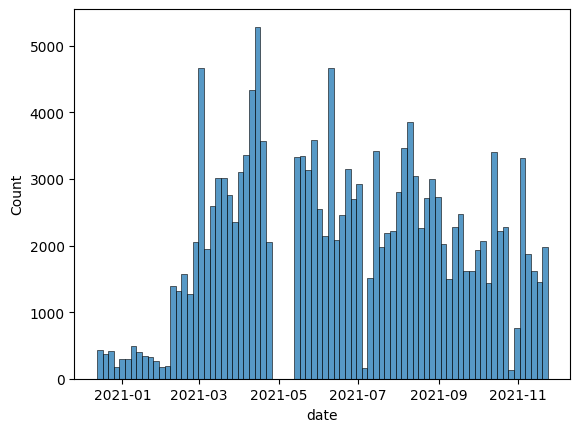

In [22]:
sns.histplot(data=df, x="date", bins=80)

<Axes: xlabel='date', ylabel='Count'>

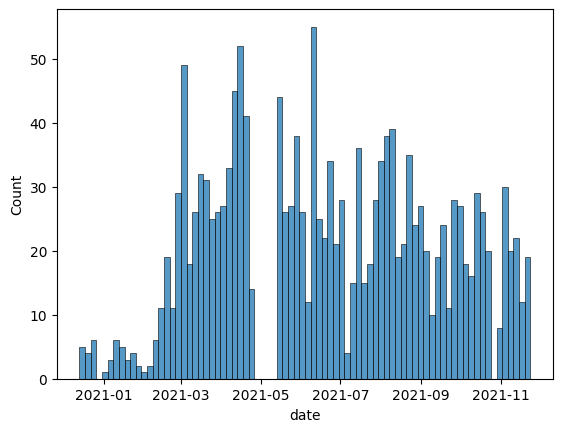

In [91]:
sns.histplot(data=downsampled_df, x="date", bins=80)

In [24]:
from transformers import pipeline
model_path = "citizenlab/twitter-xlm-roberta-base-sentiment-finetunned"

sentiment_classifier = pipeline("text-classification", model=model_path, tokenizer=model_path,
    return_all_scores=True)

config.json:   0%|          | 0.00/992 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [92]:
def get_highest_score_label(data):
    # Verifica se a lista de dados não está vazia e contém pelo menos um elemento
    if not data or not data[0]:
        return None

    # Inicializa variáveis para armazenar a maior pontuação e a label correspondente
    highest_score = 0
    highest_score_label = ""

    # Percorre cada item na lista de dicionários
    for item in data[0]:
        # Verifica se o score atual é maior que o score mais alto registrado até agora
        if item['score'] > highest_score:
            highest_score = item['score']
            highest_score_label = item['label']

    return highest_score_label

In [93]:
colunaAprovacao = []
for texto in downsampled_df['text']:
  classificacao = sentiment_classifier(texto)
  colunaAprovacao.append(get_highest_score_label(classificacao))

downsampled_df['aprovacao'] = colunaAprovacao




In [94]:
print(downsampled_df.head())

           user_name                                               text  \
0          GhoseSpot  This is wonderful news @ICMRDELHI. Now all han...   
1           𝓝𝓪𝓲𝓵𝓪𝓱 💐  Pay attention to the language.\n\n“…the first ...   
2            myth 🤘🖤  they spelled my first name wrong lmao. After t...   
3      BrickMetal 🇮🇳  @MeghaSPrasad @Sootradhar Covaxin is the best ...   
4  New York Avengers  The people who are in charge still have not fi...   

                 date           user_location   mesAno aprovacao  
0 2021-08-03 03:15:11          India-at-large  08/2021  Positive  
1 2021-08-23 17:30:09  Commonwealth of Heaven  08/2021   Neutral  
2 2021-08-14 03:23:58               Nashville  08/2021   Neutral  
3 2021-08-06 01:46:21                  mumbai  08/2021   Neutral  
4 2021-08-16 11:50:41           New York, USA  08/2021   Neutral  


In [100]:
contagem = downsampled_df.groupby(['mesAno', 'aprovacao']).size().reset_index(name='Quantidade')


In [101]:
def ordenar_e_pivotar(df, coluna_data, colunas_pivot, coluna_valor):
    # Converte a coluna 'mesAno' para o tipo datetime
    df[coluna_data] = pd.to_datetime(df[coluna_data], format='%m/%Y')

    # Adiciona uma coluna temporária para ordenação
    df['mesAno'] = df[coluna_data].dt.strftime('%Y-%m')

    # Ordena o DataFrame pela coluna temporária de ordenação
    df.sort_values(by='mesAno', inplace=True)

    # Realiza o pivotamento
    df_pivotado = df.pivot(index='mesAno', columns=colunas_pivot, values=coluna_valor)

    # Opcional: Converte a coluna 'ordenacao' de volta para o formato original de string
    df_pivotado.index = pd.to_datetime(df_pivotado.index, format='%Y-%m').strftime('%m/%Y')

    return df_pivotado

# Chamando a função
contagemPivot = ordenar_e_pivotar(contagem, 'mesAno', 'aprovacao', 'Quantidade'); contagemPivot


aprovacao,Negative,Neutral,Positive
mesAno,,,
12/2020,2,12,1
01/2021,1,19,4
02/2021,2,74,4
03/2021,11,187,15
04/2021,21,163,21
05/2021,4,130,9
06/2021,5,192,10
07/2021,5,124,8
08/2021,7,198,9


In [102]:
contagemPivot['Total'] = contagemPivot[['Negative', 'Neutral', 'Positive']].sum(axis=1); contagemPivot

aprovacao,Negative,Neutral,Positive,Total
mesAno,,,,
12/2020,2,12,1,15
01/2021,1,19,4,24
02/2021,2,74,4,80
03/2021,11,187,15,213
04/2021,21,163,21,205
05/2021,4,130,9,143
06/2021,5,192,10,207
07/2021,5,124,8,137
08/2021,7,198,9,214


In [103]:
# Calculando a frequência relativa de cada categoria
contagemPivot['Freq_Rel_Negative'] = contagemPivot['Negative'] / contagemPivot['Total']
contagemPivot['Freq_Rel_Neutral'] = contagemPivot['Neutral'] / contagemPivot['Total']
contagemPivot['Freq_Rel_Positive'] = contagemPivot['Positive'] / contagemPivot['Total']; contagemPivot

aprovacao,Negative,Neutral,Positive,Total,Freq_Rel_Negative,Freq_Rel_Neutral,Freq_Rel_Positive
mesAno,,,,,,,
12/2020,2,12,1,15,0.133333,0.800000,0.066667
01/2021,1,19,4,24,0.041667,0.791667,0.166667
02/2021,2,74,4,80,0.025000,0.925000,0.050000
03/2021,11,187,15,213,0.051643,0.877934,0.070423
04/2021,21,163,21,205,0.102439,0.795122,0.102439
05/2021,4,130,9,143,0.027972,0.909091,0.062937
06/2021,5,192,10,207,0.024155,0.927536,0.048309
07/2021,5,124,8,137,0.036496,0.905109,0.058394
08/2021,7,198,9,214,0.032710,0.925234,0.042056


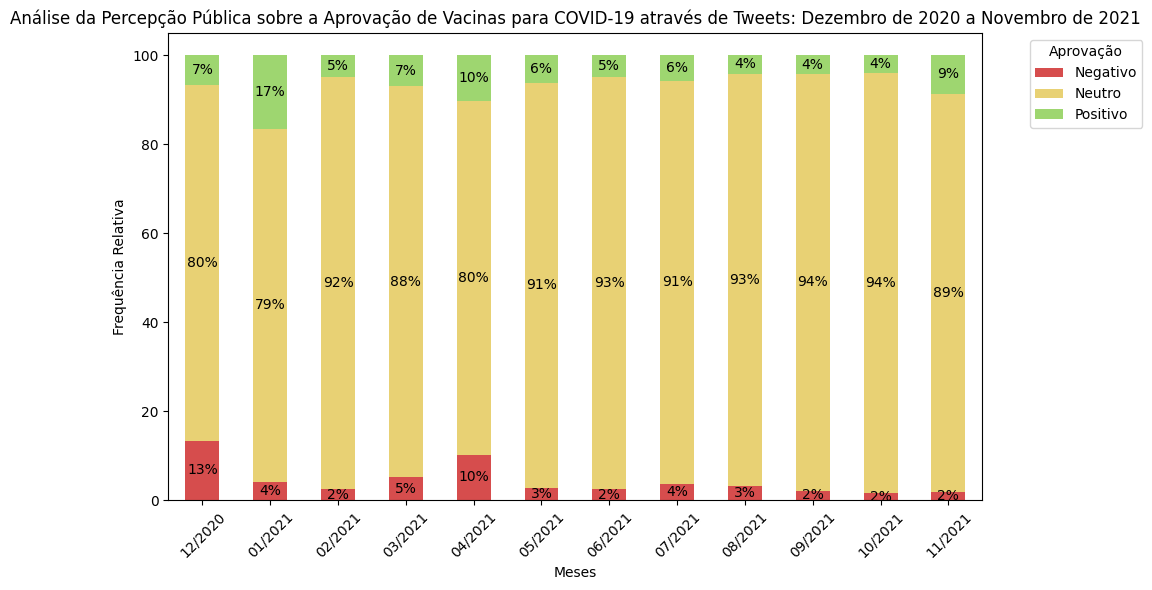

In [104]:
freq_df = contagemPivot[['Freq_Rel_Negative', 'Freq_Rel_Neutral', 'Freq_Rel_Positive']]*100
# Plotando o gráfico de barras empilhadas
# Definindo as cores para cada categoria
cores = ['#d64d4d', '#e8d174', '#9ed670']  # Substitua por suas cores desejadas

# Renomeando as categorias na legenda
nomes_legenda = ['Negativo', 'Neutro', 'Positivo']  # Substitua pelos nomes desejados


fig, ax = plt.subplots(figsize=(9,6))
freq_df.plot(kind='bar', stacked=True, ax=ax, color=cores)
ax.set_xlabel('Meses')
ax.set_ylabel('Frequência Relativa')
ax.set_title('Análise da Percepção Pública sobre a Aprovação de Vacinas para COVID-19 através de Tweets: Dezembro de 2020 a Novembro de 2021')
plt.xticks(rotation=45)
plt.tight_layout()
for bars in ax.containers:
    ax.bar_label(bars, label_type='center', fmt='%.0f%%', color='black')
ax.legend(nomes_legenda, title='Aprovação', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Alguns pontos importantes no tempo

## Dezembro de 2020

- A FDA (Administração de Alimentos e Medicamentos dos Estados Unidos) emite uma Autorização de Uso de Emergência para a vacina COVID-19 da Pfizer-BioNTech.

## Janeiro de 2021

- O número de mortes reportadas por COVID-19 nos EUA ultrapassa 400.000.

## Abril de 2021

- O CDC (Centros de Controle e Prevenção de Doenças) recomenda que pessoas que estão totalmente vacinadas contra a COVID-19 podem viajar com menor risco para si mesmas.

## Agosto de 2021

- O ACIP (Comitê Consultivo sobre Práticas de Imunização) recomenda uma dose adicional da vacina contra a COVID-19 após a série de duas doses para todas as pessoas com sistemas imunológicos moderada ou severamente comprometidos.

## Novembro de 2021

- O ACIP recomenda a vacina pediátrica Pfizer-BioNTech contra a COVID-19 para todas as crianças de 5 a 11 anos de idade.